In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heapq
import shap

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Bidirectional
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from keras.optimizers import SGD
from sklearn import preprocessing
from tensorflow import keras
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocessing data

In [3]:
df_new = pd.read_csv('MBTI_new.csv')

In [4]:
df_new['Text_stemmed'] = df_new['Text_stemmed'].astype(str)

In [5]:
df_new['Bigram'] = df_new['Bigram'].astype(str)

In [6]:
df_new = df_new[df_new['Tag']!="MBTI"]

In [7]:
df_new

,Unnamed: 0,Tag,Cleaned_Text,Cleaned_Text_No_Emoticon,Text_stemmed,Bigram,Reddit,Twitter,Typology,Kaggle
0,0,ENFJ,memeincorrect quote sure trying keep peace family,memeincorrect quote sure trying keep peace family,memeincorrect quot sure tri peac famili,memeincorrect quote sure trying keep_peace family,1,0,0,0
1,1,ENTP,memefour distinct flavors nt,memefour distinct flavors nt,memefour distinct flavor,memefour distinct flavors nt,1,0,0,0
2,2,ENTP,memethis definitely intp looks like,memethis definitely intp looks like,memethi definit intp look like,memethis definitely intp looks_like,1,0,0,0
3,3,ISFJ,theory questionwhat type admire,theory questionwhat type admire,theori questionwhat type admir,theory_questionwhat type admire,1,0,0,0
4,4,ISTJ,memeistj x enfp real,memeistj x enfp real,memeistj enfp real,memeistj x enfp real,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
127572,127572,ISFP,always think cats fi doms reason websites beco...,always think cats fi doms reason websites beco...,think cat dom reason websit nazi perci nerd le...,always think cats fi_doms reason websites beco...,0,0,0,1
127573,127573,ENFP,soif thread already exists someplace else heck...,soif thread already exists someplace else heck...,soif thread exist someplac heck delet hereooop...,soif thread already_exists someplace else heck...,0,0,0,1
127574,127574,INTP,many questions things would take purple pill p...,many questions things would take purple pill p...,question thing purpl pill pick win lotteri num...,many questions things would take purple pill p...,0,0,0,1
127575,127575,INFP,conflicted right comes wanting children honest...,conflicted right comes wanting children honest...,conflict right come want children honest mater...,conflicted right comes wanting children honest...,0,0,0,1


In [8]:
df_new['Tag'].unique()

array(['ENFJ', 'ENTP', 'ISFJ', 'ISTJ', 'INFP', 'ESTJ', 'ISTP', 'INTJ',
       'INTP', 'ENFP', 'ESTP', 'ENTJ', 'INFJ', 'ISFP', 'ESFP', 'ESFJ'],
      dtype=object)

In [9]:
df_new['E_I'] = df_new['Tag'].apply(lambda x: "E" if x in ['ENFJ', 'ENTP', 'ESTJ', 'ENFP', 'ESTP', 'ENTJ', 'ESFP', 'ESFJ'] else "I")

In [10]:
df_new['N_S'] = df_new['Tag'].apply(lambda x: "N" if x in ['ENFJ', 'ENTP', 'ENFP', 'ENTJ', 'INTP', 'INFP', 'INFJ', 'INTJ'] else "S")

In [11]:
df_new['F_T'] = df_new['Tag'].apply(lambda x: "F" if x in ['ENFJ', 'ENFP', 'ESFP', 'ESFJ', 'ISFJ', 'INFP', 'INFJ', 'ISFP'] else "T")

In [12]:
df_new['J_P'] = df_new['Tag'].apply(lambda x: "J" if x in ['ENFJ', 'ESTJ', 'ENTJ', 'ESFJ', 'ISFJ', 'ISTJ', 'INFJ', 'INTJ'] else "P")

In [14]:
df_new

,Unnamed: 0,Tag,Cleaned_Text,Cleaned_Text_No_Emoticon,Text_stemmed,Bigram,Reddit,Twitter,Typology,Kaggle,E_I,N_S,F_T,J_P
0,0,ENFJ,memeincorrect quote sure trying keep peace family,memeincorrect quote sure trying keep peace family,memeincorrect quot sure tri peac famili,memeincorrect quote sure trying keep_peace family,1,0,0,0,E,N,F,J
1,1,ENTP,memefour distinct flavors nt,memefour distinct flavors nt,memefour distinct flavor,memefour distinct flavors nt,1,0,0,0,E,N,T,P
2,2,ENTP,memethis definitely intp looks like,memethis definitely intp looks like,memethi definit intp look like,memethis definitely intp looks_like,1,0,0,0,E,N,T,P
3,3,ISFJ,theory questionwhat type admire,theory questionwhat type admire,theori questionwhat type admir,theory_questionwhat type admire,1,0,0,0,I,S,F,J
4,4,ISTJ,memeistj x enfp real,memeistj x enfp real,memeistj enfp real,memeistj x enfp real,1,0,0,0,I,S,T,J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127572,127572,ISFP,always think cats fi doms reason websites beco...,always think cats fi doms reason websites beco...,think cat dom reason websit nazi perci nerd le...,always think cats fi_doms reason websites beco...,0,0,0,1,I,S,F,P
127573,127573,ENFP,soif thread already exists someplace else heck...,soif thread already exists someplace else heck...,soif thread exist someplac heck delet hereooop...,soif thread already_exists someplace else heck...,0,0,0,1,E,N,F,P
127574,127574,INTP,many questions things would take purple pill p...,many questions things would take purple pill p...,question thing purpl pill pick win lotteri num...,many questions things would take purple pill p...,0,0,0,1,I,N,T,P
127575,127575,INFP,conflicted right comes wanting children honest...,conflicted right comes wanting children honest...,conflict right come want children honest mater...,conflicted right comes wanting children honest...,0,0,0,1,I,N,F,P


In [14]:
reddit = df_new[df_new['Reddit']==1]
Twitter = df_new[df_new['Twitter']==1]
Typology = df_new[df_new['Typology']==1]
Kaggle = df_new[df_new['Kaggle']==1]

In [15]:
print(len(reddit))
print(len(Twitter))
print(len(Typology))
print(len(Kaggle))

32150
44082
42621
8675


In [16]:
reddit

,Unnamed: 0,Tag,Cleaned_Text,Cleaned_Text_No_Emoticon,Text_stemmed,Bigram,Reddit,Twitter,Typology,Kaggle,E_I,N_S,F_T,J_P
0,0,ENFJ,memeincorrect quote sure trying keep peace family,memeincorrect quote sure trying keep peace family,memeincorrect quot sure tri peac famili,memeincorrect quote sure trying keep_peace family,1,0,0,0,E,N,F,J
1,1,ENTP,memefour distinct flavors nt,memefour distinct flavors nt,memefour distinct flavor,memefour distinct flavors nt,1,0,0,0,E,N,T,P
2,2,ENTP,memethis definitely intp looks like,memethis definitely intp looks like,memethi definit intp look like,memethis definitely intp looks_like,1,0,0,0,E,N,T,P
3,3,ISFJ,theory questionwhat type admire,theory questionwhat type admire,theori questionwhat type admir,theory_questionwhat type admire,1,0,0,0,I,S,F,J
4,4,ISTJ,memeistj x enfp real,memeistj x enfp real,memeistj enfp real,memeistj x enfp real,1,0,0,0,I,S,T,J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32194,32194,ENTJ,endearing compliment ever received goes everyo...,endearing compliment ever received goes everyo...,endear compliment receiv goe correct grammar d...,endearing compliment ever received goes everyo...,1,0,0,0,E,N,T,J
32195,32195,ENTJ,correct grammar cannot die definition defined ...,correct grammar cannot die definition defined ...,correct grammar definit defin usag use piec gr...,correct_grammar cannot die definition defined ...,1,0,0,0,E,N,T,J
32196,32196,ENTJ,believe referring linguistic drift,believe referring linguistic drift,believ refer linguist drift,believe referring linguistic drift,1,0,0,0,E,N,T,J
32197,32197,ENTJ,promise always deliver,promise always deliver,promis deliv,promise always deliver,1,0,0,0,E,N,T,J


In [17]:
reddit['Tag'].unique()

array(['ENFJ', 'ENTP', 'ISFJ', 'ISTJ', 'INFP', 'ESTJ', 'ISTP', 'INTJ',
       'INTP', 'ENFP', 'ESTP', 'ENTJ', 'INFJ', 'ISFP', 'ESFP', 'ESFJ'],
      dtype=object)

In [18]:
feat1 = pd.read_csv('All Features on Raw Data Part 1.csv')
feat1.head()

,Tag,Text,Reddit,Twitter,Typology,Kaggle,Afinn Score,Polarity,Subjectivity,Length,...,num_verb,num_adverb,num_interject,lowercase,uppercase,uppercase_num,proper cap,contractions_num,emotionalpunctuations_num,readable_num
0,INFP,Meme<3,1,0,0,0,3.0,0.0,0.000000,7,...,1,0,0,0,0,0,1,0.0,0,2
1,ENFJ,"MemeIncorrect Quote? Not so sure. Just me, try...",1,0,0,0,2.0,0.5,0.888889,83,...,2,2,0,0,0,0,1,0.0,1,16
2,INTP,MemeENFP Avatar,1,0,0,0,0.0,0.0,0.000000,16,...,0,0,0,0,0,0,1,0.0,0,2
3,ENTP,MemeFour Distinct Flavors of NT,1,0,0,0,0.0,0.3,0.300000,32,...,0,0,0,0,0,1,1,0.0,0,5
4,INTJ,StereotypesINFP 🦋,1,0,0,0,0.0,0.0,0.000000,18,...,0,0,0,0,0,0,1,0.0,0,2


In [20]:
feat2 = pd.read_csv('All Features on Raw Data Part 2.csv')
feat2.head()

,Tag,Text,Reddit,Twitter,Typology,Kaggle,hedge_perc,firstperson_perc,thirdperson_perc
0,INFP,Meme<3,1,0,0,0,0.0,0.0000,0.0
1,ENFJ,"MemeIncorrect Quote? Not so sure. Just me, try...",1,0,0,0,1.0,0.1875,0.0
2,INTP,MemeENFP Avatar,1,0,0,0,0.0,0.0000,0.0
3,ENTP,MemeFour Distinct Flavors of NT,1,0,0,0,0.4,0.0000,0.0
4,INTJ,StereotypesINFP 🦋,1,0,0,0,0.0,0.0000,0.0


In [22]:
feat_basic = pd.read_csv('Basic Features on Cleaned Data.csv')
feat_basic

,Tag,Cleaned_Text,Afinn Score,Polarity,Subjectivity,Length
0,ENFJ,memeincorrect quote sure trying keep peace family,2.0,0.500000,0.888889,49
1,ENTP,memefour distinct flavors nt,0.0,0.300000,0.300000,28
2,ENTP,memethis definitely intp looks like,2.0,0.000000,0.500000,35
3,ISFJ,theory questionwhat type admire,3.0,0.000000,0.000000,31
4,ISTJ,memeistj x enfp real,0.0,0.200000,0.300000,20
...,...,...,...,...,...,...
134164,ISFP,always think cats fi doms reason websites beco...,23.0,0.139790,0.579605,2859
134165,ENFP,soif thread already exists someplace else heck...,144.0,0.201315,0.563804,4496
134166,INTP,many questions things would take purple pill p...,11.0,0.101508,0.535257,3469
134167,INFP,conflicted right comes wanting children honest...,54.0,0.095494,0.558648,5423


In [24]:
polarity = feat_basic[['Polarity']]

In [3]:
mbti_basic = pd.read_csv('MBTI_features.csv')
mbti_basic

,Unnamed: 0,Tag,Cleaned_Text,Cleaned_Text_No_Emoticon,Text_stemmed,Bigram,Trigram,Length,Emoticons_count,Emoticons Avg,...,negative,positive,sadness,surprise,trust,emotion,Reddit,Twitter,Typology,Kaggle
0,0,ENFJ,memeincorrect quote sure trying keep peace family,memeincorrect quote sure trying keep peace family,memeincorrect quot sure tri peac famili,memeincorrect quote sure trying keep_peace family,memeincorrect quote sure trying keep_peace family,49,1,0.020408,...,0.020408,0.040816,0.000000,0.020408,0.020408,"[0, 2, 0, 0, 1, 1, 2, 0, 1, 1]",1,0,0,0
1,1,ENTP,memefour distinct flavors nt,memefour distinct flavors nt,memefour distinct flavor,memefour distinct flavors nt,memefour distinct flavors nt,28,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,[],1,0,0,0
2,2,ENTP,memethis definitely intp looks like,memethis definitely intp looks like,memethi definit intp look like,memethis definitely intp looks_like,memethis definitely intp looks_like,35,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,[],1,0,0,0
3,3,ISFJ,theory questionwhat type admire,theory questionwhat type admire,theori questionwhat type admir,theory_questionwhat type admire,theory_questionwhat type admire,31,0,0.000000,...,0.000000,0.032258,0.000000,0.000000,0.064516,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 2]",1,0,0,0
4,4,ISTJ,memeistj x enfp real,memeistj x enfp real,memeistj enfp real,memeistj x enfp real,memeistj x enfp real,20,0,0.000000,...,0.000000,0.050000,0.000000,0.000000,0.050000,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 1]",1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127578,127578,ISFP,always think cats fi doms reason websites beco...,always think cats fi doms reason websites beco...,think cat dom reason websit nazi perci nerd le...,always think cats fi_doms reason websites beco...,always think cats fi_doms reason websites beco...,2833,13,0.004589,...,0.007060,0.018708,0.002824,0.003177,0.009178,"[9, 27, 5, 12, 28, 20, 53, 8, 9, 26]",0,0,0,1
127579,127579,ENFP,soif thread already exists someplace else heck...,soif thread already exists someplace else heck...,soif thread exist someplac heck delet hereooop...,soif thread already_exists someplace else heck...,soif thread already_exists someplace_else heck...,4470,22,0.004922,...,0.004922,0.015213,0.002461,0.002908,0.007606,"[9, 28, 4, 14, 35, 22, 68, 11, 13, 34]",0,0,0,1
127580,127580,INTP,many questions things would take purple pill p...,many questions things would take purple pill p...,question thing purpl pill pick win lotteri num...,many questions things would take purple pill p...,many questions things would take purple pill p...,3409,2,0.000587,...,0.008214,0.015840,0.003227,0.003227,0.009094,"[18, 28, 10, 13, 26, 28, 54, 11, 11, 31]",0,0,0,1
127581,127581,INFP,conflicted right comes wanting children honest...,conflicted right comes wanting children honest...,conflict right come want children honest mater...,conflicted right comes wanting children honest...,conflicted right comes wanting children honest...,5396,1,0.000185,...,0.006486,0.010934,0.003706,0.001853,0.006301,"[15, 32, 8, 15, 28, 35, 59, 20, 10, 34]",0,0,0,1


In [5]:
mbti_basic['E_I'] = mbti_basic['Tag'].apply(lambda x: "E" if x in ['ENFJ', 'ENTP', 'ESTJ', 'ENFP', 'ESTP', 'ENTJ', 'ESFP', 'ESFJ'] else "I")

mbti_basic['N_S'] = mbti_basic['Tag'].apply(lambda x: "N" if x in ['ENFJ', 'ENTP', 'ENFP', 'ENTJ', 'INTP', 'INFP', 'INFJ', 'INTJ'] else "S")

mbti_basic['F_T'] = mbti_basic['Tag'].apply(lambda x: "F" if x in ['ENFJ', 'ENFP', 'ESFP', 'ESFJ', 'ISFJ', 'INFP', 'INFJ', 'ISFP'] else "T")

mbti_basic['J_P'] = mbti_basic['Tag'].apply(lambda x: "J" if x in ['ENFJ', 'ESTJ', 'ENTJ', 'ESFJ', 'ISFJ', 'ISTJ', 'INFJ', 'INTJ'] else "P")

In [6]:
mbti_basic

,Unnamed: 0,Tag,Cleaned_Text,Cleaned_Text_No_Emoticon,Text_stemmed,Bigram,Trigram,Length,Emoticons_count,Emoticons Avg,...,trust,emotion,Reddit,Twitter,Typology,Kaggle,E_I,N_S,F_T,J_P
0,0,ENFJ,memeincorrect quote sure trying keep peace family,memeincorrect quote sure trying keep peace family,memeincorrect quot sure tri peac famili,memeincorrect quote sure trying keep_peace family,memeincorrect quote sure trying keep_peace family,49,1,0.020408,...,0.020408,"[0, 2, 0, 0, 1, 1, 2, 0, 1, 1]",1,0,0,0,E,N,F,J
1,1,ENTP,memefour distinct flavors nt,memefour distinct flavors nt,memefour distinct flavor,memefour distinct flavors nt,memefour distinct flavors nt,28,0,0.000000,...,0.000000,[],1,0,0,0,E,N,T,P
2,2,ENTP,memethis definitely intp looks like,memethis definitely intp looks like,memethi definit intp look like,memethis definitely intp looks_like,memethis definitely intp looks_like,35,0,0.000000,...,0.000000,[],1,0,0,0,E,N,T,P
3,3,ISFJ,theory questionwhat type admire,theory questionwhat type admire,theori questionwhat type admir,theory_questionwhat type admire,theory_questionwhat type admire,31,0,0.000000,...,0.064516,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 2]",1,0,0,0,I,S,F,J
4,4,ISTJ,memeistj x enfp real,memeistj x enfp real,memeistj enfp real,memeistj x enfp real,memeistj x enfp real,20,0,0.000000,...,0.050000,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 1]",1,0,0,0,I,S,T,J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127578,127578,ISFP,always think cats fi doms reason websites beco...,always think cats fi doms reason websites beco...,think cat dom reason websit nazi perci nerd le...,always think cats fi_doms reason websites beco...,always think cats fi_doms reason websites beco...,2833,13,0.004589,...,0.009178,"[9, 27, 5, 12, 28, 20, 53, 8, 9, 26]",0,0,0,1,I,S,F,P
127579,127579,ENFP,soif thread already exists someplace else heck...,soif thread already exists someplace else heck...,soif thread exist someplac heck delet hereooop...,soif thread already_exists someplace else heck...,soif thread already_exists someplace_else heck...,4470,22,0.004922,...,0.007606,"[9, 28, 4, 14, 35, 22, 68, 11, 13, 34]",0,0,0,1,E,N,F,P
127580,127580,INTP,many questions things would take purple pill p...,many questions things would take purple pill p...,question thing purpl pill pick win lotteri num...,many questions things would take purple pill p...,many questions things would take purple pill p...,3409,2,0.000587,...,0.009094,"[18, 28, 10, 13, 26, 28, 54, 11, 11, 31]",0,0,0,1,I,N,T,P
127581,127581,INFP,conflicted right comes wanting children honest...,conflicted right comes wanting children honest...,conflict right come want children honest mater...,conflicted right comes wanting children honest...,conflicted right comes wanting children honest...,5396,1,0.000185,...,0.006301,"[15, 32, 8, 15, 28, 35, 59, 20, 10, 34]",0,0,0,1,I,N,F,P


In [74]:
mbti_basic['E_I'].value_counts()

I    75624
E    51959
Name: E_I, dtype: int64

In [75]:
mbti_basic['N_S'].value_counts()

N    87691
S    39892
Name: N_S, dtype: int64

In [76]:
mbti_basic['F_T'].value_counts()

T    72537
F    55046
Name: F_T, dtype: int64

In [77]:
mbti_basic['J_P'].value_counts()

P    70844
J    56739
Name: J_P, dtype: int64

In [30]:
mbti_basic.columns

Index(['Unnamed: 0', 'Tag', 'Cleaned_Text', 'Cleaned_Text_No_Emoticon',
       'Text_stemmed', 'Bigram', 'Trigram', 'Length', 'Emoticons_count',
       'Emoticons Avg', 'Unique_Words', 'TTR', 'Dominant Emotion', 'anger',
       'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive',
       'sadness', 'surprise', 'trust', 'emotion', 'Reddit', 'Twitter',
       'Typology', 'Kaggle', 'E_I', 'N_S', 'F_T', 'J_P'],
      dtype='object')

In [31]:
TTR = mbti_basic[['TTR']]
length = mbti_basic[['Length']]
positive = mbti_basic[['positive']]
negative = mbti_basic[['negative']]
emo = mbti_basic[['Emoticons Avg']]

In [33]:
# Some testing features identified to be important from literatrue were selected to run the LSTM model

scaler = preprocessing.MinMaxScaler()

ttr = TTR.values 
ttr_scaled = scaler.fit_transform(ttr)

pos = positive.values 
pos_scaled = scaler.fit_transform(pos)

neg = negative.values 
neg_scaled = scaler.fit_transform(neg)

leng = length.values 
leng_scaled = scaler.fit_transform(leng)

emo = emo.values 
emo_scaled = scaler.fit_transform(emo)

# Without feature engineering

## General tags

Found 378081 unique tokens.
Shape of data tensor: (127583, 40)
Shape of label tensor: (127583, 17)
(114824, 40) (114824, 17)
(12759, 40) (12759, 17)
Epoch 1/10
1615/1615 [==============================] - 152s 93ms/step - loss: 2.5997 - accuracy: 0.1563 - val_loss: 2.5144 - val_accuracy: 0.1975
Epoch 2/10
1615/1615 [==============================] - 143s 89ms/step - loss: 2.4299 - accuracy: 0.2259 - val_loss: 2.5325 - val_accuracy: 0.1915
Epoch 3/10
1615/1615 [==============================] - 160s 99ms/step - loss: 2.3281 - accuracy: 0.2641 - val_loss: 2.5682 - val_accuracy: 0.1933
Epoch 4/10
399/399 [==============================] - 2s 5ms/step - loss: 2.6053 - accuracy: 0.1859
Test set
  Loss: 2.605
  Accuracy: 0.186


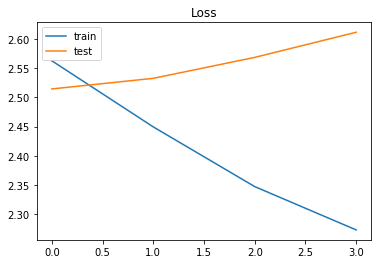

In [22]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 40 #prev 20
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(mbti_basic['Cleaned_Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(mbti_basic['Cleaned_Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(mbti_basic['Tag']).values
print('Shape of label tensor:', Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 40)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

opt = keras.optimizers.Adam(lr=0.01)

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(50, dropout=0.2))
model.add(Dropout(0.25))
model.add(Dense(17, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

#prev acc 0.613
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

## General Tags - with TF-IDF

In [58]:
# # The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
X = mbti_basic['Cleaned_Text'].values
Y = mbti_basic['Tag'].values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 40)

vectorizer_x = TfidfVectorizer(max_features=MAX_NB_WORDS)
X_train = vectorizer_x.fit_transform(X_train).toarray()
X_test = vectorizer_x.transform(X_test).toarray()
print("tf-idf with",str(np.array(X_train).shape[1]),"features")


tf-idf with 5000 features


In [59]:
X_train.shape

(114824, 5000)

In [60]:
X_train.reshape(-1, 5000, 1).shape

(114824, 5000, 1)

In [61]:
Y_train = pd.get_dummies(Y_train).values
Y_test = pd.get_dummies(Y_test).values

In [62]:
Y_train.shape

(114824, 17)

In [63]:
opt = keras.optimizers.Adam(lr=0.01)

model = Sequential()
model.add(LSTM(50, input_shape=(5000, 1)))
model.add(Dropout(0.2))
model.add(Dense(17, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [66]:
epochs = 5
batch_size = 64

history = model.fit(X_train.reshape(-1, 5000, 1), Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
1615/1615 [==============================] - 4561s 3s/step - loss: 2.6510 - accuracy: 0.1316 - val_loss: 2.6525 - val_accuracy: 0.1198
Epoch 2/5
1615/1615 [==============================] - 4896s 3s/step - loss: 2.6483 - accuracy: 0.1332 - val_loss: 2.6533 - val_accuracy: 0.1345
Epoch 3/5
1615/1615 [==============================] - 4267s 3s/step - loss: 2.6477 - accuracy: 0.1332 - val_loss: 2.6511 - val_accuracy: 0.1345
Epoch 4/5
1615/1615 [==============================] - 7108s 4s/step - loss: 2.6475 - accuracy: 0.1336 - val_loss: 2.6511 - val_accuracy: 0.1345
Epoch 5/5
1615/1615 [==============================] - 4332s 3s/step - loss: 2.6474 - accuracy: 0.1333 - val_loss: 2.6519 - val_accuracy: 0.1345


399/399 [==============================] - 159s 398ms/step - loss: 2.6489 - accuracy: 0.1317
Test set
  Loss: 2.649
  Accuracy: 0.132


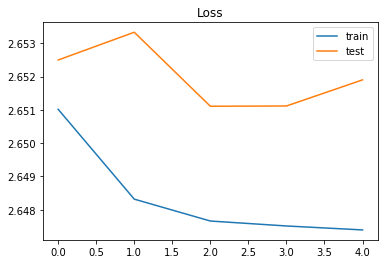

In [70]:
accr = model.evaluate(X_test.reshape(-1, 5000, 1),Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

## General Tags - with Kfold

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 40 #prev 20
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(mbti_basic['Cleaned_Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(mbti_basic['Cleaned_Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(mbti_basic['Tag']).values
print('Shape of label tensor:', Y.shape)


kfold=KFold(10,True,7)
cvscores = []

for train, test in kfold.split(X,Y):

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 40)
    
    opt = keras.optimizers.Adam(lr=0.01)

    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(LSTM(50, dropout=0.2))
    model.add(Dropout(0.25))
    model.add(Dense(17, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    model.fit(X_train, Y_train, epochs=10, batch_size=64, verbose=0, shuffle=False)
    scores = model.evaluate(X_test,Y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

## Split tag (E-I)

Found 378081 unique tokens.
Shape of data tensor: (127583, 40)
Shape of label tensor: (127583, 2)
(114824, 40) (114824, 2)
(12759, 40) (12759, 2)
Epoch 1/10
1615/1615 [==============================] - 137s 84ms/step - loss: 0.6647 - accuracy: 0.6061 - val_loss: 0.6522 - val_accuracy: 0.6206
Epoch 2/10
1615/1615 [==============================] - 135s 83ms/step - loss: 0.6040 - accuracy: 0.6690 - val_loss: 0.6693 - val_accuracy: 0.6126
Epoch 3/10
1615/1615 [==============================] - 135s 84ms/step - loss: 0.5540 - accuracy: 0.7103 - val_loss: 0.6912 - val_accuracy: 0.6091
Epoch 4/10
399/399 [==============================] - 2s 5ms/step - loss: 0.7334 - accuracy: 0.6036
Test set
  Loss: 0.733
  Accuracy: 0.604


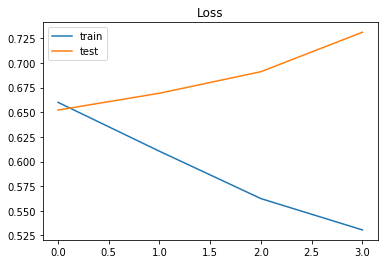

In [23]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 40 #prev 20
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(mbti_basic['Cleaned_Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(mbti_basic['Cleaned_Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(mbti_basic['E_I']).values
print('Shape of label tensor:', Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 40)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

opt = keras.optimizers.Adam(lr=0.01)

model_EI = Sequential()
model_EI.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model_EI.add(LSTM(50, dropout=0.2))
model_EI.add(Dropout(0.25))
model_EI.add(Dense(2, activation='sigmoid'))
model_EI.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model_EI.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model_EI.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

## Split tag (E-I) - with TF-IDF

In [1]:
# # The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
X = mbti_basic['Cleaned_Text'].values
Y = mbti_basic['E_I'].values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 40)

vectorizer_x = TfidfVectorizer(max_features=MAX_NB_WORDS)
X_train = vectorizer_x.fit_transform(X_train).toarray()
X_test = vectorizer_x.transform(X_test).toarray()
print("tf-idf with",str(np.array(X_train).shape[1]),"features")


print("X_train.shape: ", X_train.shape)

Y_train = pd.get_dummies(Y_train).values
Y_test = pd.get_dummies(Y_test).values

print("Y_train.shape: ", Y_train.shape)

opt = keras.optimizers.Adam(lr=0.01)

model = Sequential()
model.add(LSTM(50, input_shape=(5000, 1)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train.reshape(-1, 5000, 1), Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

## Split tag (E-I) - with Kfold

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 40 #prev 20
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(mbti_basic['Cleaned_Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(mbti_basic['Cleaned_Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(mbti_basic['E_I']).values
print('Shape of label tensor:', Y.shape)

kfold=KFold(10,True,7)
cvscores = []

for train, test in kfold.split(X,Y):

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 40)
    
    opt = keras.optimizers.Adam(lr=0.01)

    model_EI = Sequential()
    model_EI.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model_EI.add(LSTM(50, dropout=0.2))
    model_EI.add(Dropout(0.25))
    model_EI.add(Dense(2, activation='sigmoid'))
    model_EI.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    model_EI.fit(X_train, Y_train, epochs=10, batch_size=64, verbose=0, shuffle=False)
    scores = model_EI.evaluate(X_test,Y_test, verbose=0)
    print("%s: %.2f%%" % (model_EI.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# With feature engineering

## Without Kfold

## E-I 

In [96]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 40 #prev 20
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(mbti_basic['Cleaned_Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(mbti_basic['Cleaned_Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
X = np.hstack((X, ttr_scaled, pos_scaled, neg_scaled, leng_scaled, emo_scaled))
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(mbti_basic['E_I']).values
print('Shape of label tensor:', Y.shape)

Found 378081 unique tokens.
Shape of data tensor: (127583, 41)
Shape of label tensor: (127583, 2)


In [97]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 40)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(114824, 41) (114824, 2)
(12759, 41) (12759, 2)


In [98]:
opt = keras.optimizers.Adam(lr=0.01)

In [100]:
model2 = Sequential()
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model2.add(LSTM(60))
model2.add(Dropout(0.25))
model2.add(Dense(2, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model2.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 100)           5000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 60)                38640     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 122       
Total params: 5,038,762
Trainable params: 5,038,762
Non-trainable params: 0
_________________________________________________________________
None


In [101]:
epochs = 10
batch_size = 64

history = model2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
1615/1615 [==============================] - 131s 80ms/step - loss: 0.6660 - accuracy: 0.6047 - val_loss: 0.6578 - val_accuracy: 0.6111
Epoch 2/10
1615/1615 [==============================] - 139s 86ms/step - loss: 0.6186 - accuracy: 0.6588 - val_loss: 0.6689 - val_accuracy: 0.6146
Epoch 3/10
1615/1615 [==============================] - 134s 83ms/step - loss: 0.5833 - accuracy: 0.6898 - val_loss: 0.6681 - val_accuracy: 0.6160
Epoch 4/10
1615/1615 [==============================] - 135s 84ms/step - loss: 0.5587 - accuracy: 0.7048 - val_loss: 0.6982 - val_accuracy: 0.6061


In [102]:
#prev acc 0.613
accr = model2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

399/399 [==============================] - 2s 6ms/step - loss: 0.7054 - accuracy: 0.5998
Test set
  Loss: 0.705
  Accuracy: 0.600


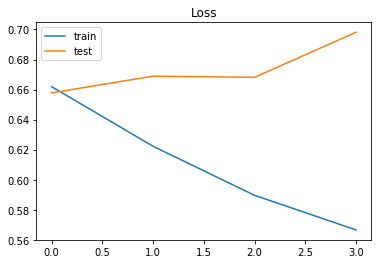

In [103]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [61]:
X_train_sample = X_train[0:3000]

In [104]:
pred = model2.predict(X_test)

In [105]:
pred.shape

(12759, 2)

In [106]:
pred[7]

array([0.14160088, 0.8583755 ], dtype=float32)

In [107]:
X_test_texts = tokenizer.sequences_to_texts(X_test)

In [108]:
len(X_test_texts)

12759

In [109]:
E_I = pd.get_dummies(mbti_basic['E_I']).columns

In [110]:
E_I

Index(['E', 'I'], dtype='object')

In [111]:
closest_tag = []
actual_tag = []
for i in range(0, len(pred)):
    ind1 = heapq.nlargest(1, range(len(pred[i])), key=pred[i].__getitem__)
    closest_tag.append(E_I[ind1])
    actual_tag.append(E_I[np.argmax(Y_test[i])])

In [112]:
df = {'test posts': X_test_texts, 'actual tags':actual_tag, 'predicted tags':closest_tag}

In [113]:
test_results = pd.DataFrame(df)

In [114]:
test_results.head(50)

,test posts,actual tags,predicted tags
0,intp listed lmao,I,"Index(['I'], dtype='object')"
1,youre killin softly man,E,"Index(['E'], dtype='object')"
2,always listening music mean life musical,I,"Index(['I'], dtype='object')"
3,yeah agree nedom hell lol,E,"Index(['E'], dtype='object')"
4,watched danny youtube video tried make perfect...,E,"Index(['E'], dtype='object')"
5,empathy people able feel unsure living diary s...,I,"Index(['I'], dtype='object')"
6,would think something necessarily anything des...,E,"Index(['I'], dtype='object')"
7,intp fi like,I,"Index(['I'], dtype='object')"
8,yall see im poet,I,"Index(['E'], dtype='object')"
9,ordered kg sweet potatoes sent one single muta...,I,"Index(['I'], dtype='object')"


## N-S

In [4]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 40 #prev 20
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(mbti_basic['Cleaned_Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(mbti_basic['Cleaned_Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
X = np.hstack((X, ttr_scaled, pos_scaled, neg_scaled, leng_scaled, emo_scaled))
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(mbti_basic['N_S']).values
print('Shape of label tensor:', Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 40)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

opt = keras.optimizers.Adam(lr=0.01)

model_NS = Sequential()
model_NS.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model_NS.add(LSTM(60, dropout=0.2))
model_NS.add(Dropout(0.25))
model_NS.add(Dense(2, activation='sigmoid'))
model_NS.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model_NS.summary())

epochs = 10
batch_size = 64

history = model_NS.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

#prev acc 0.613
accr = model_NS.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [75]:
pred = model_NS.predict(X_test)

X_test_texts = tokenizer.sequences_to_texts(X_test)

N_S = pd.get_dummies(mbti_basic['N_S']).columns

closest_tag = []
actual_tag = []
for i in range(0, len(pred)):
    ind1 = heapq.nlargest(1, range(len(pred[i])), key=pred[i].__getitem__)
    closest_tag.append(N_S[ind1])
    actual_tag.append(N_S[np.argmax(Y_test[i])])

df = {'test posts': X_test_texts, 'actual tags':actual_tag, 'predicted tags':closest_tag}

test_results = pd.DataFrame(df)

test_results.tail(50)

,test posts,actual tags,predicted tags
12709,asal tgk balik dh,S,"Index(['S'], dtype='object')"
12710,seems many people agree two different reasons,N,"Index(['S'], dtype='object')"
12711,happens dont heal inner child spend entire lif...,N,"Index(['N'], dtype='object')"
12712,cant get job bachelors finance undergraduate m...,N,"Index(['S'], dtype='object')"
12713,short answer yes long answer,N,"Index(['N'], dtype='object')"
12714,mean describe general terms inaccurate quite n...,N,"Index(['N'], dtype='object')"
12715,niggas add close friends say let,S,"Index(['S'], dtype='object')"
12716,still fucked fact fbi doj even thinking prosec...,N,"Index(['N'], dtype='object')"
12717,feel like give guy energy drink might let go w...,N,"Index(['S'], dtype='object')"
12718,,S,"Index(['S'], dtype='object')"


## With Kfold

## E-I

In [117]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 40 #prev 20
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(mbti_basic['Cleaned_Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(mbti_basic['Cleaned_Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
X = np.hstack((X, ttr_scaled, pos_scaled, neg_scaled, leng_scaled, emo_scaled))
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(mbti_basic['E_I']).values
print('Shape of label tensor:', Y.shape)

Found 378081 unique tokens.
Shape of data tensor: (127583, 45)
Shape of label tensor: (127583, 2)


In [119]:
kfold=KFold(10,True,7)
cvscores = []

Pass shuffle=True, random_state=7 as keyword args. From version 0.25 passing these as positional arguments will result in an error


In [121]:
for train, test in kfold.split(X,Y):

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 40)
    
    opt = keras.optimizers.Adam(lr=0.01)

    model_EI = Sequential()
    model_EI.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model_EI.add(LSTM(50, dropout=0.2))
    model_EI.add(Dropout(0.25))
    model_EI.add(Dense(2, activation='sigmoid'))
    model_EI.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    model_EI.fit(X_train, Y_train, epochs=10, batch_size=64, verbose=0, shuffle=False)
    scores = model_EI.evaluate(X_test,Y_test, verbose=0)
    print("%s: %.2f%%" % (model_EI.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

accuracy: 59.36%
accuracy: 59.80%
accuracy: 59.35%
accuracy: 60.35%
accuracy: 59.60%
accuracy: 60.16%
accuracy: 60.15%
accuracy: 60.15%
accuracy: 60.62%
accuracy: 60.47%
60.00% (+/- 0.43%)


In [122]:
pred = model2.predict(X_test)

print('Predictions shape: ', pred.shape)

X_test_texts = tokenizer.sequences_to_texts(X_test)

E_I = pd.get_dummies(mbti_basic['E_I']).columns

closest_tag = []
actual_tag = []
for i in range(0, len(pred)):
    ind1 = heapq.nlargest(1, range(len(pred[i])), key=pred[i].__getitem__)
    closest_tag.append(E_I[ind1])
    actual_tag.append(E_I[np.argmax(Y_test[i])])

df = {'test posts': X_test_texts, 'actual tags':actual_tag, 'predicted tags':closest_tag}

test_results = pd.DataFrame(df)

test_results.head(50)

Predictions shape:  (12759, 2)


,test posts,actual tags,predicted tags
0,intp listed lmao,I,"Index(['I'], dtype='object')"
1,youre killin softly man,E,"Index(['E'], dtype='object')"
2,always listening music mean life musical,I,"Index(['I'], dtype='object')"
3,yeah agree nedom hell lol,E,"Index(['E'], dtype='object')"
4,watched danny youtube video tried make perfect...,E,"Index(['E'], dtype='object')"
5,empathy people able feel unsure living diary s...,I,"Index(['I'], dtype='object')"
6,would think something necessarily anything des...,E,"Index(['I'], dtype='object')"
7,intp fi like,I,"Index(['I'], dtype='object')"
8,yall see im poet,I,"Index(['I'], dtype='object')"
9,ordered kg sweet potatoes sent one single muta...,I,"Index(['I'], dtype='object')"


## F-T

In [39]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 40 #prev 20
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(mbti_basic['Cleaned_Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(mbti_basic['Cleaned_Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
X = np.hstack((X, ttr_scaled, pos_scaled, neg_scaled, leng_scaled, emo_scaled))
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(mbti_basic['F_T']).values
print('Shape of label tensor:', Y.shape)

Found 378081 unique tokens.
Shape of data tensor: (127583, 45)
Shape of label tensor: (127583, 2)


In [41]:
kfold=KFold(10,True,7)
cvscores = []

for train, test in kfold.split(X,Y):

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 40)
    
    opt = keras.optimizers.Adam(lr=0.01)

    model_FT = Sequential()
    model_FT.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model_FT.add(LSTM(50, dropout=0.2))
    model_FT.add(Dropout(0.25))
    model_FT.add(Dense(2, activation='sigmoid'))
    model_FT.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    model_FT.fit(X_train, Y_train, epochs=10, batch_size=64, verbose=0, shuffle=False)
    scores = model_FT.evaluate(X_test,Y_test, verbose=0)
    print("%s: %.2f%%" % (model_FT.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

accuracy: 58.99%
accuracy: 60.17%
accuracy: 59.77%
accuracy: 59.41%
accuracy: 59.50%
accuracy: 60.04%
accuracy: 59.63%
accuracy: 60.07%
accuracy: 58.99%
accuracy: 59.40%
59.60% (+/- 0.40%)


In [43]:
pred = model_FT.predict(X_test)

print('Predictions shape: ', pred.shape)

X_test_texts = tokenizer.sequences_to_texts(X_test)

F_T = pd.get_dummies(mbti_basic['F_T']).columns

closest_tag = []
actual_tag = []
for i in range(0, len(pred)):
    ind1 = heapq.nlargest(1, range(len(pred[i])), key=pred[i].__getitem__)
    closest_tag.append(F_T[ind1])
    actual_tag.append(F_T[np.argmax(Y_test[i])])

df = {'test posts': X_test_texts, 'actual tags':actual_tag, 'predicted tags':closest_tag}

test_results = pd.DataFrame(df)

test_results.head(50)

Predictions shape:  (12759, 2)


,test posts,actual tags,predicted tags
0,intp listed lmao,T,"Index(['T'], dtype='object')"
1,youre killin softly man,T,"Index(['T'], dtype='object')"
2,always listening music mean life musical,F,"Index(['T'], dtype='object')"
3,yeah agree nedom hell lol,T,"Index(['F'], dtype='object')"
4,watched danny youtube video tried make perfect...,T,"Index(['T'], dtype='object')"
5,empathy people able feel unsure living diary s...,F,"Index(['T'], dtype='object')"
6,would think something necessarily anything des...,T,"Index(['T'], dtype='object')"
7,intp fi like,T,"Index(['T'], dtype='object')"
8,yall see im poet,F,"Index(['F'], dtype='object')"
9,ordered kg sweet potatoes sent one single muta...,F,"Index(['T'], dtype='object')"


In [44]:
from keras.models import load_model

model_FT.save('model_FT.h5')

## N-S

In [25]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 40 #prev 20
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(mbti_basic['Cleaned_Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(mbti_basic['Cleaned_Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
X = np.hstack((X, ttr_scaled, pos_scaled, neg_scaled, leng_scaled, emo_scaled))
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(mbti_basic['N_S']).values
print('Shape of label tensor:', Y.shape)

Found 378081 unique tokens.
Shape of data tensor: (127583, 45)
Shape of label tensor: (127583, 2)


In [27]:
kfold=KFold(10,True,7)
cvscores = []

for train, test in kfold.split(X,Y):

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 40)
    
    opt = keras.optimizers.Adam(lr=0.01)

    model_NS = Sequential()
    model_NS.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model_NS.add(LSTM(50, dropout=0.2))
    model_NS.add(Dropout(0.25))
    model_NS.add(Dense(2, activation='sigmoid'))
    model_NS.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    model_NS.fit(X_train, Y_train, epochs=10, batch_size=64, verbose=0, shuffle=False)
    scores = model_NS.evaluate(X_test,Y_test, verbose=0)
    print("%s: %.2f%%" % (model_NS.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

accuracy: 69.43%
accuracy: 69.39%
accuracy: 69.43%
accuracy: 69.28%
accuracy: 69.67%
accuracy: 69.36%
accuracy: 69.26%
accuracy: 69.08%
accuracy: 69.28%
accuracy: 69.72%
69.39% (+/- 0.18%)


In [29]:
pred = model_NS.predict(X_test)

print('Predictions shape: ', pred.shape)

X_test_texts = tokenizer.sequences_to_texts(X_test)

N_S = pd.get_dummies(mbti_basic['N_S']).columns

closest_tag = []
actual_tag = []
for i in range(0, len(pred)):
    ind1 = heapq.nlargest(1, range(len(pred[i])), key=pred[i].__getitem__)
    closest_tag.append(N_S[ind1])
    actual_tag.append(N_S[np.argmax(Y_test[i])])

df = {'test posts': X_test_texts, 'actual tags':actual_tag, 'predicted tags':closest_tag}

test_results = pd.DataFrame(df)

test_results.head(50)

Predictions shape:  (12759, 2)


,test posts,actual tags,predicted tags
0,intp listed lmao,N,"Index(['N'], dtype='object')"
1,youre killin softly man,N,"Index(['N'], dtype='object')"
2,always listening music mean life musical,N,"Index(['N'], dtype='object')"
3,yeah agree nedom hell lol,N,"Index(['N'], dtype='object')"
4,watched danny youtube video tried make perfect...,N,"Index(['N'], dtype='object')"
5,empathy people able feel unsure living diary s...,N,"Index(['N'], dtype='object')"
6,would think something necessarily anything des...,S,"Index(['N'], dtype='object')"
7,intp fi like,N,"Index(['N'], dtype='object')"
8,yall see im poet,N,"Index(['N'], dtype='object')"
9,ordered kg sweet potatoes sent one single muta...,N,"Index(['N'], dtype='object')"


## J-P

In [34]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 40 #prev 20
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(mbti_basic['Cleaned_Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(mbti_basic['Cleaned_Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
X = np.hstack((X, ttr_scaled, pos_scaled, neg_scaled, leng_scaled, emo_scaled))
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(mbti_basic['J_P']).values
print('Shape of label tensor:', Y.shape)

Found 378081 unique tokens.
Shape of data tensor: (127583, 45)
Shape of label tensor: (127583, 2)


In [35]:
kfold=KFold(10,True,7)
cvscores = []

for train, test in kfold.split(X,Y):

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 40)
    
    opt = keras.optimizers.Adam(lr=0.01)
    
    model_JP = Sequential()
    model_JP.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model_JP.add(LSTM(50, dropout=0.2))
    model_JP.add(Dropout(0.25))
    model_JP.add(Dense(2, activation='sigmoid'))
    model_JP.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    model_JP.fit(X_train, Y_train, epochs=10, batch_size=64, verbose=0, shuffle=False)
    scores = model_JP.evaluate(X_test,Y_test, verbose=0)
    print("%s: %.2f%%" % (model_JP.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


Pass shuffle=True, random_state=7 as keyword args. From version 0.25 passing these as positional arguments will result in an error


accuracy: 57.95%
accuracy: 57.92%
accuracy: 58.99%
accuracy: 58.17%
accuracy: 58.11%
accuracy: 58.01%
accuracy: 58.74%
accuracy: 57.58%
accuracy: 58.06%
accuracy: 57.95%
58.15% (+/- 0.39%)


In [36]:
pred = model_JP.predict(X_test)

print('Predictions shape: ', pred.shape)

X_test_texts = tokenizer.sequences_to_texts(X_test)

J_P = pd.get_dummies(mbti_basic['J_P']).columns

closest_tag = []
actual_tag = []
for i in range(0, len(pred)):
    ind1 = heapq.nlargest(1, range(len(pred[i])), key=pred[i].__getitem__)
    closest_tag.append(J_P[ind1])
    actual_tag.append(J_P[np.argmax(Y_test[i])])

df = {'test posts': X_test_texts, 'actual tags':actual_tag, 'predicted tags':closest_tag}

test_results = pd.DataFrame(df)

test_results.head(50)

from keras.models import load_model

model_JP.save('model_JP.h5')

Predictions shape:  (12759, 2)


In [37]:
test_results.head(50)

,test posts,actual tags,predicted tags
0,intp listed lmao,P,"Index(['P'], dtype='object')"
1,youre killin softly man,J,"Index(['J'], dtype='object')"
2,always listening music mean life musical,J,"Index(['J'], dtype='object')"
3,yeah agree nedom hell lol,P,"Index(['P'], dtype='object')"
4,watched danny youtube video tried make perfect...,P,"Index(['P'], dtype='object')"
5,empathy people able feel unsure living diary s...,J,"Index(['P'], dtype='object')"
6,would think something necessarily anything des...,J,"Index(['J'], dtype='object')"
7,intp fi like,P,"Index(['P'], dtype='object')"
8,yall see im poet,P,"Index(['J'], dtype='object')"
9,ordered kg sweet potatoes sent one single muta...,J,"Index(['J'], dtype='object')"
